In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### Retrieve data

In [2]:
# Read dataset
data_folder = './data/'
data=pd.read_csv(data_folder + 'marketing_campaign.csv',header=0,sep=';', index_col = 'ID')

In [3]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,4/9/2012,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,8/3/2014,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21/8/2013,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10/2/2014,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19/1/2014,94,173,43,...,5,0,0,0,0,0,0,3,11,0


### Analyze data and rename columns

In [4]:
# Calculate client's age
data['Age'] = 2021 - data['Year_Birth']

# Calculate total spent
data['Total_Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

#Seniority variable creation
last_date = date(2021, 12, 13)

In [5]:
# Calculate clients's seniority
data['Seniority']=pd.to_datetime(data['Dt_Customer'], dayfirst=True, format='%d/%m/%Y')
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')/30

# Rename some columns
data=data.rename(columns={'NumWebPurchases': "Web_Purchases",
                          'NumCatalogPurchases':'Catalog_Purchases',
                          'NumStorePurchases':'Store_Purchases', 
                          'NumWebVisitsMonth':'Web_Visits_Month',
                          'MntWines': "Wines",
                          'MntFruits':'Fruits',
                          'MntMeatProducts':'Meat',
                          'MntFishProducts':'Fish',
                          'MntSweetProducts':'Sweets',
                          'MntGoldProds':'Gold'})

# Calculate the amount of children that a client has
data['Children'] = data['Kidhome'] + data['Teenhome']
data['Has_Child'] = np.where(data.Children > 0, 1, 0)

# Filter just relevant client's features
data=data[['Age','Education','Marital_Status','Income','Total_Spent','Seniority','Has_Child', 'Children', 'Wines','Fruits','Meat','Fish','Sweets','Gold','Web_Purchases','Catalog_Purchases','Store_Purchases','Web_Visits_Month']]
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,112.900000,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,94.566667,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,101.200000,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,95.433333,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,96.166667,1,1,173,43,118,46,27,15,5,3,6,5


In [6]:
import math
def plot_features():
    columns = data.columns
    features = len(columns)
    COLUMNS = 3
    ROWS = math.ceil(features/COLUMNS)

    fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12,10))

    for i in range(0, features):
        current_column = i % COLUMNS
        current_row = i//COLUMNS
        # Get the axis where to add the plot
        ax = axs[current_row, current_column]
        data[columns[i]].hist(bins=20, ax=ax, alpha=0.6)
        ax.set_title(columns[i])
    
    plt.tight_layout()

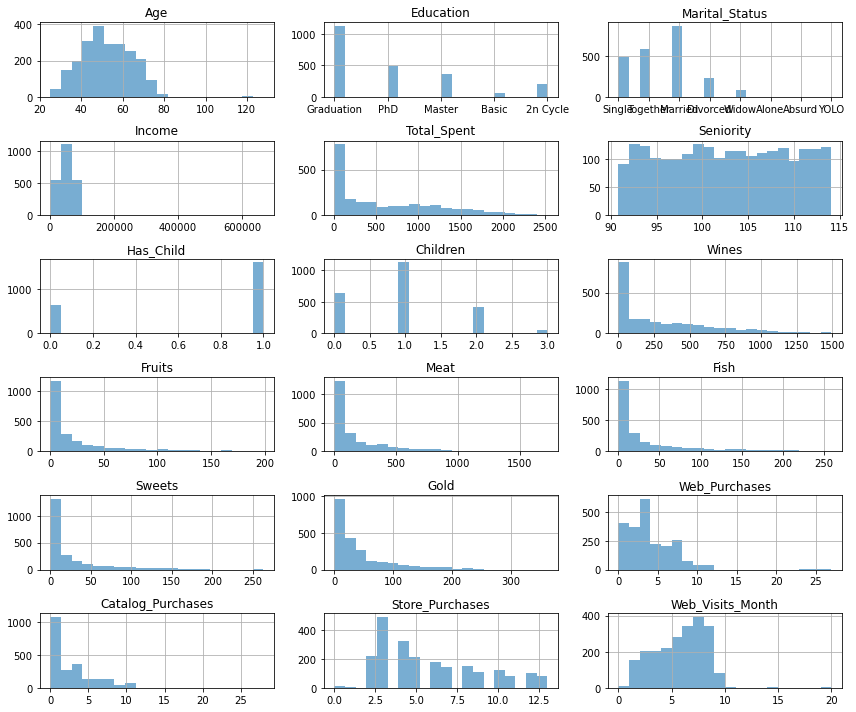

In [7]:
# Plot features after cleaning the data
plot_features()

### Clean data

In [8]:
# Check amount of initial null values
print('Amount of null values',len(data[data.isna().any(axis=1)]))
print(data.mean().mean())

Amount of null values 24
3352.071702915485


In [9]:
# Fill null values with mean income amount according its education level
data['Income'].fillna(data.groupby('Education')['Income'].transform('mean'), inplace=True)

In [10]:
# Check the amount of null values after cleaning the data
print('Amount of null values after cleaning the data',len(data[data.isna().any(axis=1)]))

Amount of null values after cleaning the data 0


In [11]:
# Check max and min values in Income column
my_max = data['Income'].loc[data['Income'].idxmax()]
print(my_max)
my_min = data['Income'].loc[data['Income'].idxmin()]
print(my_min)

666666.0
1730.0


In [12]:
# Remove outliers
data = data[data['Income'] < 600000]

In [13]:
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,112.900000,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,94.566667,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,101.200000,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,95.433333,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,96.166667,1,1,173,43,118,46,27,15,5,3,6,5


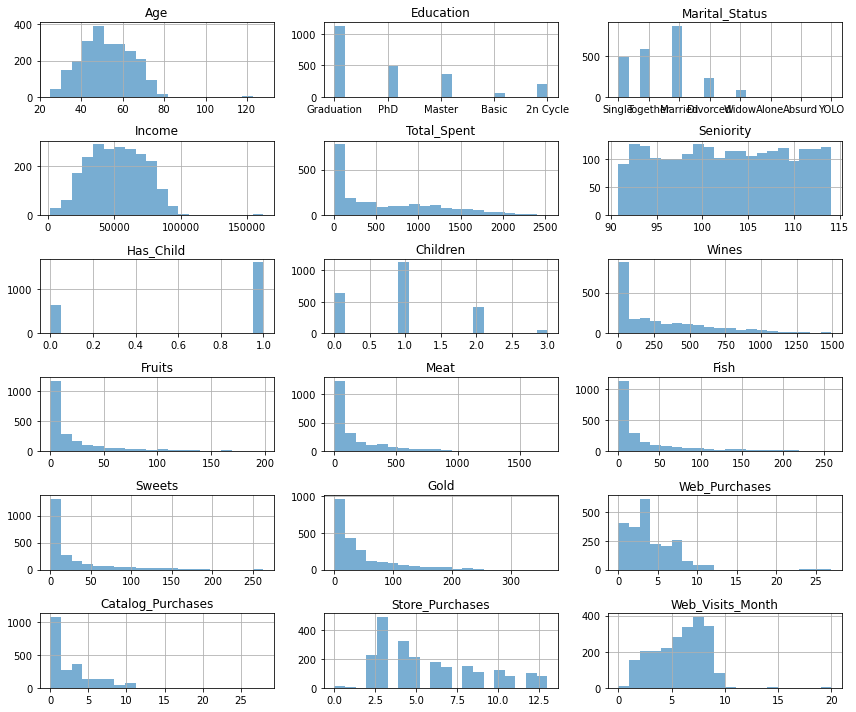

In [14]:
# Plot again after cleaning the data
plot_features()

### Create Labels

In [15]:
# Adding labels to DataFrame
data['Spent_More_In_Food_Than_Gold'] = np.where(data['Total_Spent'] > data['Gold'], 1, 0)

data['Spent_More_In_Wines_Than_Meat'] = np.where(data['Wines'] > data['Meat'], 1, 0)
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month,Spent_More_In_Food_Than_Gold,Spent_More_In_Wines_Than_Meat
ID,,,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,112.900000,0,0,635,88,546,172,88,88,8,10,4,7,1,1
2174,67,Graduation,Single,46344.0,27,94.566667,1,2,11,1,6,2,1,6,1,1,2,5,1,1
4141,56,Graduation,Together,71613.0,776,101.200000,0,0,426,49,127,111,21,42,8,2,10,4,1,1
6182,37,Graduation,Together,26646.0,53,95.433333,1,1,11,4,20,10,3,5,2,0,4,6,1,0
5324,40,PhD,Married,58293.0,422,96.166667,1,1,173,43,118,46,27,15,5,3,6,5,1,1


### Standarization

In [16]:
# Standarize data
scaler=StandardScaler()
dataset_temp=data[['Income','Seniority','Total_Spent']]
X_std=scaler.fit_transform(dataset_temp)
X = normalize(X_std,norm='l2')
X

array([[ 0.12561574,  0.66844995,  0.73307254],
       [-0.16954246, -0.76657774, -0.61936574],
       [ 0.93454332, -0.20954399,  0.28761103],
       ...,
       [ 0.16003001, -0.67286651,  0.72224722],
       [ 0.60781205, -0.73662257,  0.29656651],
       [ 0.02749673,  0.8785579 , -0.47684373]])